# *The Art of Natural Language Processing: RNNs for the Case Study*

### **Authors: Andrea Ferrario, Mara Nägelin**

**Date: February 2020** (updated September 2020)

Notebook to run the RNNs in the Contemporary Approach, as described in the tutorial `The Art of Natural Language Processing: Classical, Modern and Contemporary Approaches to Text Document Classification'.

# Table of contents
1. [Getting started with Python and Jupyter Notebook](#datagen)
2. [Import data](#datagen)
3. [Data preprocessing](#dataprep)  
    3.1. [Remove duplicates](#remdup)  
    3.2. [Shuffle the data](#shuffle)  
    3.3. [Minimal preprocessing (detailed)](#prep_det)  
    3.4. [Minimal preprocessing with Keras](#prep_keras)  
4. [Deep learning](#DL)  
    4.1. [Train test split](#trainsplit)  
    4.2. [Define the model](#modeldef)  
    .......4.2.1. [Shallow LSTM](#LSTM1)  
    .......4.2.2. [Shallow GRU](#GRU1)  
    .......4.2.3. [Deep LSTM](#LSTM2)    
    4.3. [Train the model](#trainmodel)  
    4.4. [Evaluate the model on test data](#evalmodel)  
5. [Final remarks](#fm)

<a name="started"></a>
# 1. Getting started with Python and Jupyter Notebook

In this section, Jupyter Notebook and Python settings are initialized. For code in Python, the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) ("PEP = Python Enhancement Proposal") is enforced with minor variations to improve readibility.

In [1]:
# Notebook settings
###################

# resetting variables
get_ipython().magic('reset -sf') 

# formatting: cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# plotting
%matplotlib inline

<a id='datagen'></a>

# 2. Import data

First, we import the raw data from the original 50'000 text files and save to a dataframe. This only needs to be run once. After that, one can start directly with [Section 2](#dataprep). The following code snippet is based on the book `Python Machine Learning` by Raschka and Mirjalili, Chapter 8 (see tutorial).

In [2]:
import pyprind
import pandas as pd
import os
basepath = 'path_to_extracted_data/aclImdb/' # TODO: update to point to your data repository

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], 
                           ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:46


In [3]:
# save as csv 
path = "path_to_save_data/movie_data.csv" # TODO: update to your path
df.to_csv(path, index=False, encoding='utf-8')

<a id='dataprep'></a>

# 3. Data preprocessing

Next we preprare the raw data such that in can be used as input for a neural network. Again, we follow the example of Raschka and Mirjalili (Chapter 16). We perform the following steps:

* We remove all duplicates.
* We shuffle the data in a random permutation.
* We apply only minimal preprocessing (i.e. convert to lowercase and split on whitespaces and punctuation).
* We map each word bijectively to an integer value.
* We set each review to an equal length $T$ by padding with $0$ or slicing as required.

The last three steps are written out in detail in [Section 2.3.](#prep_det) to give the reader an understanding of what exactly happens to the data. However, they can also be carried out — almost equivalently — using the high-level `text.preprocessing` functionalities of the `tensorflow.keras` module, see [Section 2.4.](#prep_keras) The user needs to run only one of these two subsections to preprocess the data.

The transformed data is stored in a dataframe for convenience. Hence [Section 2](#dataprep) also needs to be run only once, and after one can start jump directly to [Section 3](#DL).

The following can be used to reimport the dataframe with the raw data generated in [Section 1](#datagen) above.

In [4]:
# import the data
import pandas as pd
import os

path = 'path_to_save_data/movie_data.csv' # TODO: update to your path  
df = pd.read_csv(path, encoding='utf-8') # read in the dataframe stored as csv
df.shape

(50000, 2)

<a id='remdup'></a>

## 3.1. Remove duplicates

In [5]:
# check for duplicates - we found them, even with HTML markup...
duplicates = df[df.duplicated()]  # Duplicated rows, except the first entry, are marked as 'True'
print(len(duplicates))

418


In [6]:
# a check on the duplicated review
duplicates.review   # some appear more than once, as they originally appear 3 or more times in the dataset

33       I was fortunate to attend the London premier o...
177      I've been strangely attracted to this film sin...
939      The Andrew Davies adaptation of the Sarah Wate...
1861     <br /><br />First of all, I reviewed this docu...
1870     Spheeris debut must be one of the best music d...
                               ...                        
49412    There is no way to avoid a comparison between ...
49484    **SPOILERS** I rented "Tesis" (or "Thesis" in ...
49842    'Dead Letter Office' is a low-budget film abou...
49853    This movie had a IMDB rating of 8.1 so I expec...
49864    You know all those letters to "Father Christma...
Name: review, Length: 418, dtype: object

In [7]:
# remove duplicates: 49582 + 418 = 50000
df = df.drop_duplicates()
df.shape

(49582, 2)

In [8]:
# double check
df[df.duplicated(subset='review')]

,review,sentiment


<a id='shuffle'></a>

## 3.2. Shuffle the data

In [9]:
# We shuffle the data to ensure randomness in the training input
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True) # reset the index after the permutation

<a id='prep_det'></a>

## 3.3. Minimal preprocessing (detailed)

The following snippets are in part adapted from Raschka and Mirjalili (Chapter 16).

In [10]:
# Minimal preprocessing and generating word counts:
#  - we surround all punctuation by whitespaces
#  - all text is converted to lowercase
#  - word counts are generated by splitting the text on whitespaces
import pyprind
from string import punctuation
from collections import Counter

counts = Counter()
pbar = pyprind.ProgBar(len(df['review']), title='Counting words occurrences')
for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' '  
                    for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split()) # splitting on whitespace

Counting words occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:16


In [11]:
# get the size of the vocabulary
print('Number of unique words:', len(counts))

Number of unique words: 102966


In [12]:
# investigate how many words appear only rarely in the reviews
print('Number of words that appear more than once:', 
      len([k for k, v in counts.items() if v > 1]))
print('Number of words that appear more than 30 times:', 
      len([k for k, v in counts.items() if v > 30]))

Number of words that appear more than once: 62923
Number of words that appear more than 30 times: 15282


In [13]:
# hence we use only the 15'000 most common in our vocabulary 
# this will make training more efficient without loosing too much information
vocab_size = 15000

# create a dictionary with word:integer pairs for all unique words
word_counts = sorted(counts, key=counts.get, reverse=True)
word_counts = word_counts[0:vocab_size]
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

In [14]:
# Mapping words to integers
# create a list with all reviews in integer coded form
mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), title='Map reviews to ints')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] 
                           for word in review.split() 
                           if word in word_to_int.keys()])
    pbar.update()

Map reviews to ints
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


In [15]:
# get the median length of the mapped review sequences to inform the choice of sequence_length
print('Median length of mapped reviews:',
      np.median([len(review) for review in mapped_reviews]))

Median length of mapped reviews: 213.0


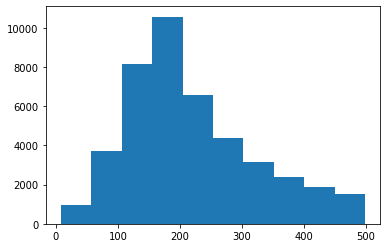

In [16]:
import matplotlib.pyplot as plt
rev_lengths = np.array([len(review) for review in mapped_reviews])
plt.hist(rev_lengths[rev_lengths < 500])
plt.show()

In [17]:
# Padding: set sequence length and ensure all mapped reviews are coerced to required length
# if sequence length < T: left-pad with zeros
# if sequence length > T: use the last T elements
sequence_length = 200  # (Known as T in our RNN formulae)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)

for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

In [18]:
# create df with processed data
df_processed = pd.concat([df['sentiment'],pd.DataFrame(sequences)], axis=1)
df_processed.head()

,sentiment,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
0,1,4,961,306,581,82,97,1,76,2,...,11,1945,1209,2,1881,3,2612,3,5244,2218
1,1,0,0,0,0,0,0,0,0,0,...,14,8,21,147,1074,25,463,6240,41,41
2,1,3,359,1,109,3,44,2053,9122,6,...,3996,678,105,1908,2667,2,5,360,24,2
3,1,0,0,0,0,0,0,0,0,0,...,1,2728,16,4074,40,493,7,89,14,2
4,0,19,1440,19,723,19,1855,19,1440,19,...,1201,19,2294,6281,10,64,6112,771,100,2


<a id='prep_keras'></a>

## 3.4. Minimal preprocessing with Keras

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 15000

# map words to integers including minimal preprocessing
tokenizer = Tokenizer(num_words=vocab_size, 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # filters out all punctuation other than '
                      lower=True, # convert to lowercase
                      split=' ') # split on whitespaces
tokenizer.fit_on_texts(df['review'])
list_tokenized = tokenizer.texts_to_sequences(df['review'])

# Padding to sequence_length
sequence_length = 200
sequences = pad_sequences(list_tokenized, maxlen=sequence_length)

# create df with processed data
df_processed = pd.concat([df['sentiment'], pd.DataFrame(sequences)], axis=1)
df_processed.head()

,sentiment,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
0,1,1786,1003,1427,3,832,7,20,48,3,...,20,1132,8,8,1923,1192,1859,2590,5216,2194
1,1,0,0,0,0,0,0,0,0,0,...,23,263,9,6,14,133,1057,18,448,6213
2,1,6,6,10587,27,3,1133,1637,374,26,...,12,997,3971,663,93,1886,2643,3,345,17
3,1,0,0,0,0,0,0,0,0,0,...,10,1,2706,11,4049,31,478,5,77,9
4,0,10588,3559,461,4106,14422,116,2,3836,560,...,117,13,1183,2271,6295,7,53,6085,755,88


<br>  
<br>
Lastly, we save the fully preprocesssed data to csv for further use.

In [20]:
# save as csv 
path = "path_to_save_data/movie_data_processed.csv" # TODO: update to your path
df_processed.to_csv(path, index=False, encoding='utf-8')

<a id='DL'></a>

# 4. Deep Learning

In this section, we reproduce the results from Section 6.4.6-6.4.7 of the tutorial. We split the preprocessed data into a training and a testing set and define our RNN model (three different possible architectures are given as examples, see [Sections 4.2.1.-4.2.3](#LSTM1). The model is compiled and trained using the high-level `tensorflow.keras` API. Finally, the development of loss and accuracy during the training is plotted and the fitted model is evaluated on the test data.  

**WARNING:** Note that training with a large training dataset for a large number of epochs is computationally intensive and might easily take a couple of hours on a normal CPU machine. We recommend subsetting the training and testing datasets and/or using an HPC infrastructure.

In [21]:
# to ensure that all keras functionalities work as intended
from __future__ import absolute_import, division, print_function, unicode_literals

In [22]:
# import the data
import pandas as pd
import os
import numpy as np

path = "path_to_save_data/movie_data_processed.csv" # TODO: update to your path
df_processed = pd.read_csv(path, encoding='utf-8')
df_processed.shape

(49582, 201)

<a id='trainsplit'></a>

## 4.1. Train test split

In [23]:
# get the number of samples for the training and test datasets
perc_train = 0.8
n_train = round(df_processed.shape[0]*perc_train)
n_test = round(df_processed.shape[0]*(1-perc_train))

print(str(int(perc_train*100))+'/'+str(int(100-perc_train*100))+' train test split:', 
      n_train, '/', n_test)

80/20 train test split: 39666 / 9916


In [24]:
# create the training and testing datasets
X_train = np.array(df_processed.head(n_train).drop('sentiment', axis=1)) # replace with n_train
y_train = df_processed.head(n_train).sentiment.values

X_test = np.array(df_processed.tail(n_test).drop('sentiment', axis=1)) # replace with n_test
y_test = df_processed.tail(n_test).sentiment.values

print('Training data shape check X, y:', X_train.shape, y_train.shape)
print('Testing data shape check X, y:', X_test.shape, y_test.shape)

Training data shape check X, y: (39666, 200) (39666,)
Testing data shape check X, y: (9916, 200) (9916,)


<a id='modeldef'></a>

## 4.2. Define the model

In [25]:
import collections
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# get the total number of words in vocabulary (+1 for the padding with 0)
vocab_size = df_processed.drop('sentiment', axis=1).values.max() + 1
print('Vocabulary size:', vocab_size-1)

Vocabulary size: 14999


Each of the following subsections defines a distinct model architecture. The user can select and run one of them.

<a id='LSTM1'></a>

### 4.2.1. Shallow LSTM architecture

This a shallow RNN with just one LSTM layer. The same architecture was used for the example by Raschka and Marjili.

In [26]:
# Create a new model
model = tf.keras.Sequential()

# Add an Embedding layer expecting input of the size of the vocabulary, and
# the embedding output dimension
model.add(layers.Embedding(input_dim=vocab_size, output_dim=256)) 

# Add a LSTM layer with 128 internal units
model.add(layers.LSTM(128))

# Add a Dropout layer to avoid overfitting
model.add(layers.Dropout(0.5))

# Add Dense layer as output layer with 1 unit and sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

<a id='GRU1'></a>

### 4.2.2. Shallow GRU architecture

This is essentially the same shallow RNN as above with a GRU layer instead of the LSTM.

In [27]:
# Create a new model
model = tf.keras.Sequential()

# Add an Embedding layer expecting input of the size of the vocabulary, and
# the embedding output dimension
model.add(layers.Embedding(input_dim=vocab_size, output_dim=256)) 

# Add a GRU layer with 128 internal units
model.add(layers.GRU(128))

# Add a Dropout layer to avoid overfitting
model.add(layers.Dropout(0.5))

# Add Dense layer as output layer with 1 unit and sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

<a id='LSTM3'></a>

### 4.2.3. Deep LSTM architecture

We can easily deepen our network by stacking a second LSTM layer on top of the first.

In [28]:
# Create a new model
model = tf.keras.Sequential()

# Add an Embedding layer expecting input of the size of the vocabulary, and
# the embedding output dimension
model.add(layers.Embedding(input_dim=vocab_size, output_dim=256)) 

# Add a LSTM layer with 128 internal units
# Return sequences so we can stack the the next LSTM layer on top
model.add(layers.LSTM(128, return_sequences=True))

# Add a second LSTM layer
model.add(layers.LSTM(128))

# Add a Dropout layer to avoid overfitting
model.add(layers.Dropout(0.5))

# Add Dense layer as output layer with 1 unit and sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

<a id='trainmodel'></a>

## 4.3. Train the model

In [29]:
# print the summary of the model we have defined
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         3840000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 4,168,833
Trainable params: 4,168,833
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# compile the model
# we select here the optimizer, loss and metric to be used in training
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]

**WARNING**: as mentioned in the tutorial, the following training routine is computationally intensive. We recommend to sub-sample data in [Section 4.1.](#trainsplit) and/or use HPC infrastructure. 
Note that we ran all the machine learning routines presented in this section on the ETH High Performance Computing (HPC) infrastructure [Euler](https://scicomp.ethz.ch/wiki/Euler), by submitting all jobs to a virtual machine consisting of 32 cores with 3072 MB RAM per core (total RAM: 98.304 GB). Therefore, notebook outputs are not available for the subesquent cells.

In [ ]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2,
                    epochs=30, 
                    batch_size=256,
                    callbacks=callbacks,
                    verbose=1)

In [ ]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

<a id='evalmodel'></a>

## 4.4. Evaluate the model on test data

In [ ]:
from sklearn.metrics import roc_auc_score

# evalute model to get accuracy and loss on test data
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)

# calculate AUC on test data
y_pred = model.predict_proba(X_test, batch_size=256)
auc_res = roc_auc_score(y_test, y_pred[:, 0])

print('Test loss:', results[0])
print('Test accuracy:', results[1])
print('Test AUC:', auc_res)

<a id='fm'></a>

# 5. Final remarks

The above example RNNs are simple architectures where none of the parameters were optimized for performance. In order to further improve the model accuracy, we could for example
* play around with the network architecture    
     (e.g. the depth of the network, the type of layers used, the number of hidden units within a layer, the activation functions used, ...)
* fine-tune the training parameters   
     (i.e. the number of epochs, batch size, ...)
* perform more elaborate preprocessing on the data  
    (e.g. excluding stopwords, see also the two other Notebooks and Section 1 of the tutorial)
* use a the weights of an already trained embedding for our embedding layer  
    (either as nontrainable fixed weights or with transfer learning, compare the Notebook ```NLP_IMDb_Case_Study_ML.ipynb``` and Section 3 of the tutorial)  

Finally, note that the size of the dataset is arguably still too small to allow for much improvement over the presented architectures and results.